# 6. XRF emission line overlap and lanthanum K-edge
## Summary
This notebook plots emission line overlap for the major K ad L- line XRF emissions. Energies are those reported in the X-ray data booklet. 

In [1]:
import pathlib
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

from matplotlib.colors import LogNorm, Normalize
from shutil import copyfile
from imctools.io.mcd.mcdparser import McdParser

import sys
sys.path.insert(0, '..\\code\\')
import high_plex_hdf

In [2]:
# Set data directory to work from 
base_dir = "C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF"
base_dir = pathlib.Path(base_dir)

# Specify the input directory where hdf files to process are located
input_dir = base_dir / 'data' / 'raw' / 'imc' / 'gelatin_standard_scans'

# Gather filepaths for preprocessed hdfs and config files for XRF fitting
imc_filepaths = list(input_dir.glob('*/*.mcd'))

# Make output directory for unpacked IMC files
out_dir = base_dir / 'data' / 'analysis' / 'xrf' / '6_XRF_emission_line_overlap'
out_dir.mkdir(parents=True, exist_ok=True)
print('Detection limits will be output to: \n\t', out_dir) 

# Import periodic table csv
df_emission_lines = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'XRF_emission_lines.csv')

Detection limits will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\xrf\6_XRF_emission_line_overlap


In [3]:
df_k_lines = df_emission_lines[['Atomic number', 'Element', 'Kalpha1', 'Kalpha2', 'Kbeta1']]
df_l_lines = df_emission_lines[['Atomic number', 'Element', 'Lalpha1', 'Lalpha2', 'Lbeta1', 'Lbeta2', 'Lgamma1']]

In [4]:
def emission_line_overlap_calculate(df, element_steps):
    df_tidy_lines = df.melt(id_vars=['Atomic number', 'Element'],
                            var_name = 'Emission line',
                            value_name='Energy (eV)'
                           )
    
    overlap_dict = [
        'Atomic number',
        'Element',
        'element step',
        'line1',
        'line2',
        'line1_energy',
        'line2_energy',        
        'line distance (eV)'
    ]
    overlap_dict= dict.fromkeys(overlap_dict)
    
    df_overlaps = pd.DataFrame(columns=overlap_dict)
     
    for z_num in df_tidy_lines['Atomic number'].unique():
        overlap_dict['Atomic number'] = z_num
        overlap_dict['Element'] = (
            df_tidy_lines['Element'][df_tidy_lines['Atomic number'] == z_num].iloc[0]
        )
                    
        for step in element_steps:
            overlap_dict['element step'] = step
            
            for line1 in df_tidy_lines['Emission line'].unique():
                overlap_dict['line1'] = line1

                overlap_dict['line1_energy'] = df_tidy_lines['Energy (eV)'][
                        (df_tidy_lines['Emission line'] == line1) &
                        (df_tidy_lines['Atomic number'] == z_num)
                ].iloc[0]
                
                if (z_num + step) not in list(df_tidy_lines['Atomic number']):
                    overlap_dict['line2'] = np.nan
                    overlap_dict['line2_energy'] = np.nan
                    overlap_dict['line distance (eV)'] = np.nan
                    df_overlaps = df_overlaps.append(overlap_dict, ignore_index=True)
                
                if (z_num + step) in list(df_tidy_lines['Atomic number']):
                    for line2 in df_tidy_lines['Emission line'].unique():
                        overlap_dict['line2'] = line2

                        overlap_dict['line2_energy'] = df_tidy_lines['Energy (eV)'][
                            (df_tidy_lines['Emission line'] == line2) &
                            (df_tidy_lines['Atomic number'] == z_num + step)
                        ].iloc[0]

                        if pd.isna(overlap_dict['line1_energy']):
                            pass
                        if pd.isna(overlap_dict['line2_energy']):
                            pass

                        else:
                            overlap_dict['line distance (eV)'] = abs(overlap_dict['line1_energy'] - overlap_dict['line2_energy'])                        
                            df_overlaps = df_overlaps.append(overlap_dict, ignore_index=True)

    return df_tidy_lines, df_overlaps
    

In [5]:
# Plot emission line overlaps
def emission_line_overlap_plot(df_overlaps, font_scale=1, ylim = (10, 10000), savename=None):   
    sns.set_style("darkgrid")
    sns.set(font_scale=font_scale)

    #plt.figure(figsize=(45,10))
    g = sns.FacetGrid(data = df_overlaps[~df_overlaps['line distance (eV)'].isna()],
                      row = 'line1',
                      col = 'line2',
                      hue = 'element step',
                      ylim = ylim,
                      #aspect = 1.5,
                      #height=height,
                      #legend_out = True
                      )
    g = g.map(sns.scatterplot, 'Atomic number', 'line distance (eV)')
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    g.add_legend()
    g.fig.get_axes()[0].set_yscale('log')


    for ax in plt.gcf().get_axes():
        ax.axvspan(57, 71, alpha=0.3, color='grey')
        ax.axhline(360, color='red', alpha = 0.5)
        ax.axhline(355, color='black', alpha = 0.5)
        ax.axhline(200, color='blue', alpha = 0.5)

        ax.annotate('Vortex SDD', xy = (0, 365), color = 'red', fontsize=10, verticalalignment = 'bottom')
        ax.annotate('Mirion GeCMOS', xy = (0, 350), color = 'black', fontsize=10, verticalalignment = 'top')
        ax.annotate('200 eV', xy = (0, 195), color = 'blue', fontsize=10, verticalalignment = 'top')
        
    if savename != None:
        print(savename)
        plt.savefig(savename, bbox_inches='tight')
        
    plt.show()


C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\xrf\6_XRF_emission_line_overlap\ExtFig1B_Koverlaps.svg


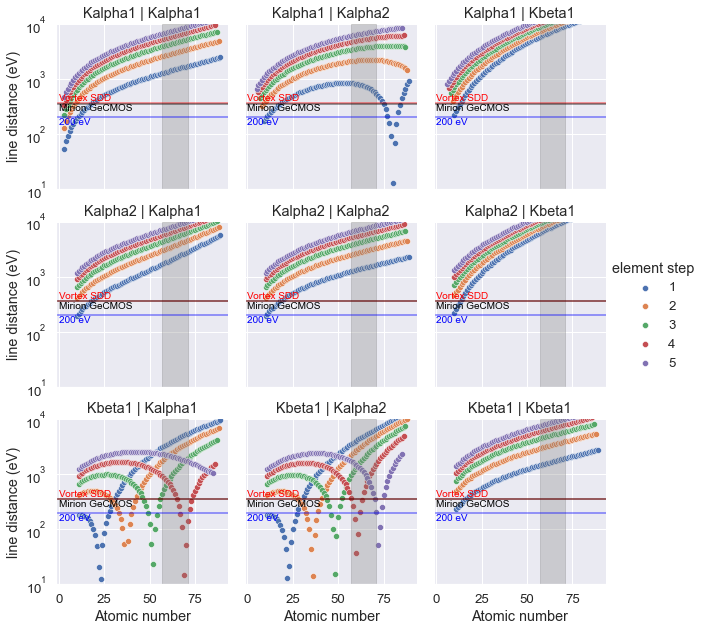

In [6]:
df_tidy_lines, df_overlaps = emission_line_overlap_calculate(df_k_lines, range(1, 6))   
savename = out_dir / 'ExtFig1B_Koverlaps.svg'
emission_line_overlap_plot(df_overlaps, font_scale=1.2, savename=savename)


In [ ]:
df_tidy_lines, df_overlaps = emission_line_overlap_calculate(df_l_lines, range(1, 10))   
savename = out_dir / 'ExtFig1C_Loverlaps.svg'
emission_line_overlap_plot(df_overlaps, font_scale=1.2, savename=savename)


In [ ]:
# Import calibrate 1 second exports of thin film standard
df_GeCMOS_1s = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'lanthanum_kedge' / '1_axo_GeCMOS.csv')
df_GeCMOS_1s['detector'] = 'GeCMOS'
df_SDD_1s = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'lanthanum_kedge' / '1_axo_SDD.csv')
df_SDD_1s['detector'] = 'SDD'

In [ ]:
df_det_1s = pd.concat([df_SDD_1s, df_GeCMOS_1s])

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,12), dpi=300)

sns.set_style("dark")
g1 = sns.lineplot(
    data = df_det_1s, 
    x = 'energy', 
    y = 'counts',
    hue = 'detector',
    palette=['black', 'blue'],
    style = 'detector',
    dashes = ['', (3,1)],
    ax=axs[0],
    legend='full'
)

axs[0].set_xlim([0,70])
axs[0].set_xticks(list(range(0, 70, 10)))
axs[0].set_xticks(list(range(0, 70, 2)), minor=True)

g2 = sns.lineplot(
    data = df_det_1s, 
    x = 'energy', 
    y = 'counts',
    hue = 'detector',
    palette=['black', 'blue'],
    style = 'detector',
    dashes = ['', (3,1)],
    ax=axs[1],
    legend='full'
)

axs[1].set_xlim([25,42])
axs[1].set_xticks(list(range(25, 42, 5)))
axs[1].set_xticks(list(range(25, 42, 1)), minor=True)

for ax in axs:
    #ax.set(yscale="log")
    #ax.yaxis.set_major_formatter(ScalarFormatter())
    #ax.set_ylim([0.5,1500])
    ax.set_yticks(list(range(0, 1000, 200)))
    ax.set_yticks(list(range(0, 1000, 50)), minor=True)

    #Set gridlines
    ax.grid(which='major', c='w', lw=3, axis='y')
    ax.grid(which='major', c='w', lw=2, axis='x')
    ax.grid(which='minor', c='w', lw=1, axis='y')
    ax.grid(which='minor', c='w', lw=1, axis='x')
    ax.set_ylabel('XRF detector counts')
    ax.set_xlabel('Energy (keV)')

    
savename = out_dir / 'ExtFig2_DetResolution.svg'
print(savename)
plt.savefig(savename, bbox_inches='tight')

plt.show()